In [1]:
import xarray as xr
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
import glob,os
from tqdm import tqdm
import datetime
import proplot as plot
%matplotlib inline

In [2]:
plot.rc.update({'figure.facecolor':'w','axes.labelweight':'ultralight',
                'tick.labelweight':'ultralight','gridminor.linestyle':'--','title.weight':'normal','linewidth':0.5})

### Read in azimuthal data

In [3]:
origin_path = '/scratch/06040/tg853394/tc/output/redux/maria/'
def read_some_azimuth_fields(fileloc=None,fieldname=None):
    dict_name = {}
    for inx,obj in enumerate(fileloc):
        field_read = xr.open_dataset(obj)
        dict_name[fieldname[inx]] = field_read
    return dict_name

In [4]:
ctrl_U,ctrl_V = origin_path+'ctl/azim_U10_0-144hr.nc',origin_path+'ctl/azim_V10_0-144hr.nc'
lwcrf_U,lwcrf_V = origin_path+'lwcrf/azim_U10_36-144hr.nc',origin_path+'lwcrf/azim_V10_36-144hr.nc'
ncrf_36h_U,ncrf_36h_V = origin_path+'ncrf_36h/azim_U10_36-144hr.nc',origin_path+'ncrf_36h/azim_V10_36-144hr.nc'
ncrf_60h_U,ncrf_60h_V = origin_path+'ncrf_60h/azim_U10_60-144hr.nc',origin_path+'ncrf_60h/azim_V10_60-144hr.nc'
ncrf_96h_U,ncrf_96h_V = origin_path+'ncrf_96h/azim_U10_96-144hr.nc',origin_path+'ncrf_96h/azim_V10_96-144hr.nc'

In [5]:
ctrl_dict = read_some_azimuth_fields(fileloc=[ctrl_U,ctrl_V],fieldname=['U','V'])
lwcrf_dict = read_some_azimuth_fields(fileloc=[lwcrf_U,lwcrf_V],fieldname=['U','V'])
ncrf_36h_dict = read_some_azimuth_fields(fileloc=[ncrf_36h_U,ncrf_36h_V],fieldname=['U','V'])
ncrf_60h_dict = read_some_azimuth_fields(fileloc=[ncrf_60h_U,ncrf_60h_V],fieldname=['U','V'])
ncrf_96h_dict = read_some_azimuth_fields(fileloc=[ncrf_96h_U,ncrf_96h_V],fieldname=['U','V'])

#### Maximum Winds (T. Beucler)

In [6]:
def nearest_index(array, value):
    idx = (np.abs(array-value)).argmin()
    return idx.values

In [7]:
US_ctrl = np.sqrt(ctrl_dict['U'].U10**2+ctrl_dict['V'].V10**2)
US_lwcrf = np.sqrt(lwcrf_dict['U'].U10**2+lwcrf_dict['V'].V10**2)
US_ncrf36 = np.sqrt(ncrf_36h_dict['U'].U10**2+ncrf_36h_dict['V'].V10**2)
US_ncrf60 = np.sqrt(ncrf_60h_dict['U'].U10**2+ncrf_60h_dict['V'].V10**2)
US_ncrf96 = np.sqrt(ncrf_96h_dict['U'].U10**2+ncrf_96h_dict['V'].V10**2)

i500 = nearest_index(ctrl_dict['U'].radius,500)
USmaxname = ['USmax_ctrl','USmax_lwcrf','USmax_ncrf36h','USmax_ncrf60h','USmax_ncrf96h']
USmax_s = {}
for inx,obj in enumerate([US_ctrl,US_lwcrf,US_ncrf36,US_ncrf60,US_ncrf96]):
    USmax_s[USmaxname[inx]] = np.max(obj[:,0,:,:i500],axis=(1,2))

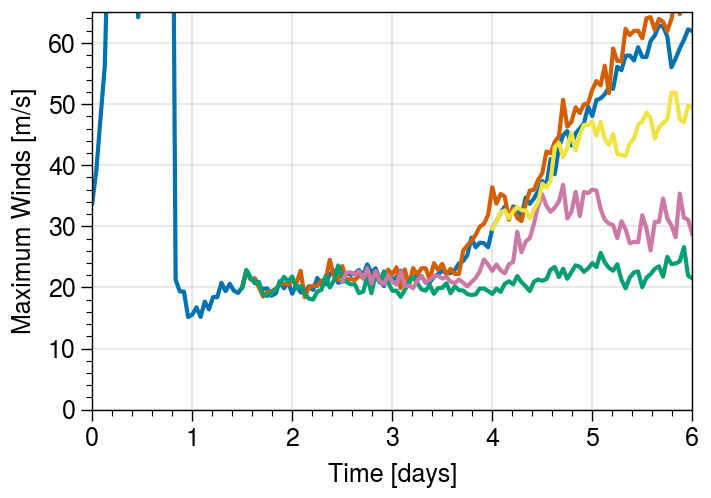

In [8]:
fig,axs = plot.subplots(ncols=1,nrows=1,axwidth=3,refaspect=1.51,span=False)
axs[0].plot(ctrl_dict['U'].time/24,USmax_s['USmax_ctrl'])
axs[0].plot(lwcrf_dict['U'].time/24+36/24,USmax_s['USmax_lwcrf'])
axs[0].plot(ncrf_36h_dict['U'].time/24+36/24,USmax_s['USmax_ncrf36h'])
axs[0].plot(ncrf_60h_dict['U'].time/24+60/24,USmax_s['USmax_ncrf60h'])
axs[0].plot(ncrf_96h_dict['U'].time/24+96/24,USmax_s['USmax_ncrf96h'])
axs[0].format(xlabel='Time [days]',ylabel='Maximum Winds [m/s]',ylim=[0,65])
plt.show()

#### Method 2: Maximum of azimuthal-averaged tangential winds

In [9]:
def ruppert_vtmax_calc(datadict=None,outer_limit=i500):
    d2r = np.pi/180
    try:
        wdir = (np.arctan(datadict['V'].V10/datadict['U'].U10)/d2r).values
    except:
        print('Cannot find wind field arrays!')
    loc_neg = (datadict['U'].U10<0)
    wdir[loc_neg] += 180
    wspd = np.sqrt(datadict['U'].U10**2+datadict['V'].V10**2).values
    az = datadict['U'].azmiuth.values
    azt = np.moveaxis(np.tile(az,(datadict['U'].U10.shape[0],1,433,1)),-1,-2)
    Urad = wspd*np.cos((wdir-azt)*d2r)
    Vtan = wspd*np.sin((wdir-azt)*d2r)
    Vtan_max = np.max(np.mean(Vtan[:,0,:,:i500],axis=1),axis=1)
    return Urad,Vtan,Vtan_max

In [10]:
_,_,ctrlVtanmax = ruppert_vtmax_calc(datadict=ctrl_dict,outer_limit=i500)
_,_,lwcrfVtanmax = ruppert_vtmax_calc(datadict=lwcrf_dict,outer_limit=i500)
_,_,ncrf_36hVtanmax = ruppert_vtmax_calc(datadict=ncrf_36h_dict,outer_limit=i500)
_,_,ncrf_60hVtanmax = ruppert_vtmax_calc(datadict=ncrf_60h_dict,outer_limit=i500)
_,_,ncrf_96hVtanmax = ruppert_vtmax_calc(datadict=ncrf_96h_dict,outer_limit=i500)

#### Intensification Rate

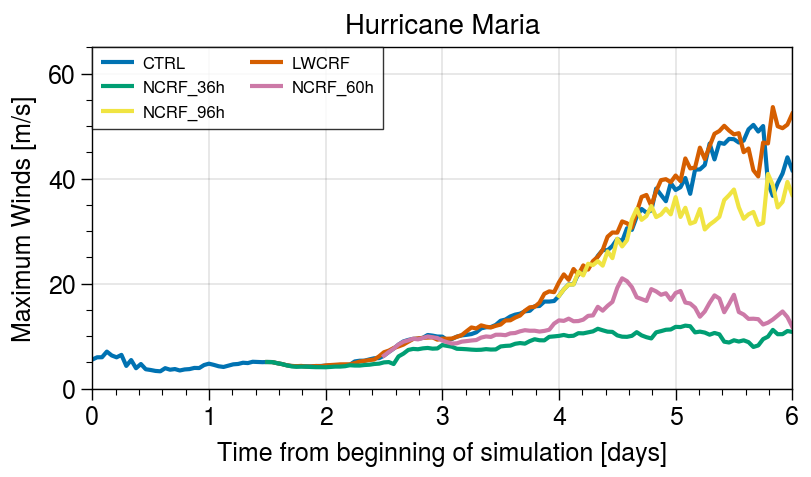

In [11]:
from scipy.ndimage.filters import uniform_filter1d
fig,axs = plot.subplots(ncols=1,nrows=1,axwidth=3.5,refaspect=2.051,span=False)

#axs[0].plot(dataU.time/24,US_max,label='Using u,v')
axs[0].plot(ctrl_dict['U'].time/24,ctrlVtanmax,label='CTRL')
axs[0].plot(lwcrf_dict['U'].time/24+36/24,lwcrfVtanmax,label='LWCRF')
axs[0].plot(ncrf_36h_dict['U'].time/24+36/24,ncrf_36hVtanmax,label='NCRF_36h')
axs[0].plot(ncrf_60h_dict['U'].time/24+60/24,ncrf_60hVtanmax,label='NCRF_60h')
axs[0].plot(ncrf_96h_dict['U'].time/24+96/24,ncrf_96hVtanmax,label='NCRF_96h')

#axs[0].plot(dataU.time/24,Vtan_max,label='Using azim-mean(vtan)',lw=1,ls='--',color='r')
#axs[0].plot(dataU.time/24,uniform_filter1d(Vtan_max,12),label='azim-mean(vtan),smoothed',lw=2.5,ls='-',color='r')
axs[0].format(xlabel='Time from beginning of simulation [days]',ylabel='Maximum Winds [m/s]',ylim=[0,65],title='Hurricane Maria')
axs[0].legend(loc='ul',ncols=2,prop={'size':6})
plt.show()

In [ ]:
import pandas as pd
wdw=3
smoovtanmax_dict = {'ctrl':uniform_filter1d(ctrlVtanmax,wdw),'lwcrf':uniform_filter1d(lwcrfVtanmax,wdw),'ncrf36':uniform_filter1d(ncrf_36hVtanmax,wdw),\
                    'ncrf60':uniform_filter1d(ncrf_60hVtanmax,wdw),'ncrf96':uniform_filter1d(ncrf_96hVtanmax,wdw)}
testctrl = pd.DataFrame({'CTRL': np.gradient(smoovtanmax_dict['ctrl'],ctrl_dict['U'].time/24)})
test_lwcrf = pd.DataFrame({'lwcrf':np.gradient(smoovtanmax_dict['lwcrf'],lwcrf_dict['U'].time/24+36/24)})
test_ncrf36 = pd.DataFrame({'NCRF_36h':np.gradient(smoovtanmax_dict['ncrf36'],ncrf_36h_dict['U'].time/24+36/24)})
test_ncrf60 = pd.DataFrame({'NCRF_60h':np.gradient(smoovtanmax_dict['ncrf60'],ncrf_60h_dict['U'].time/24+60/24)})

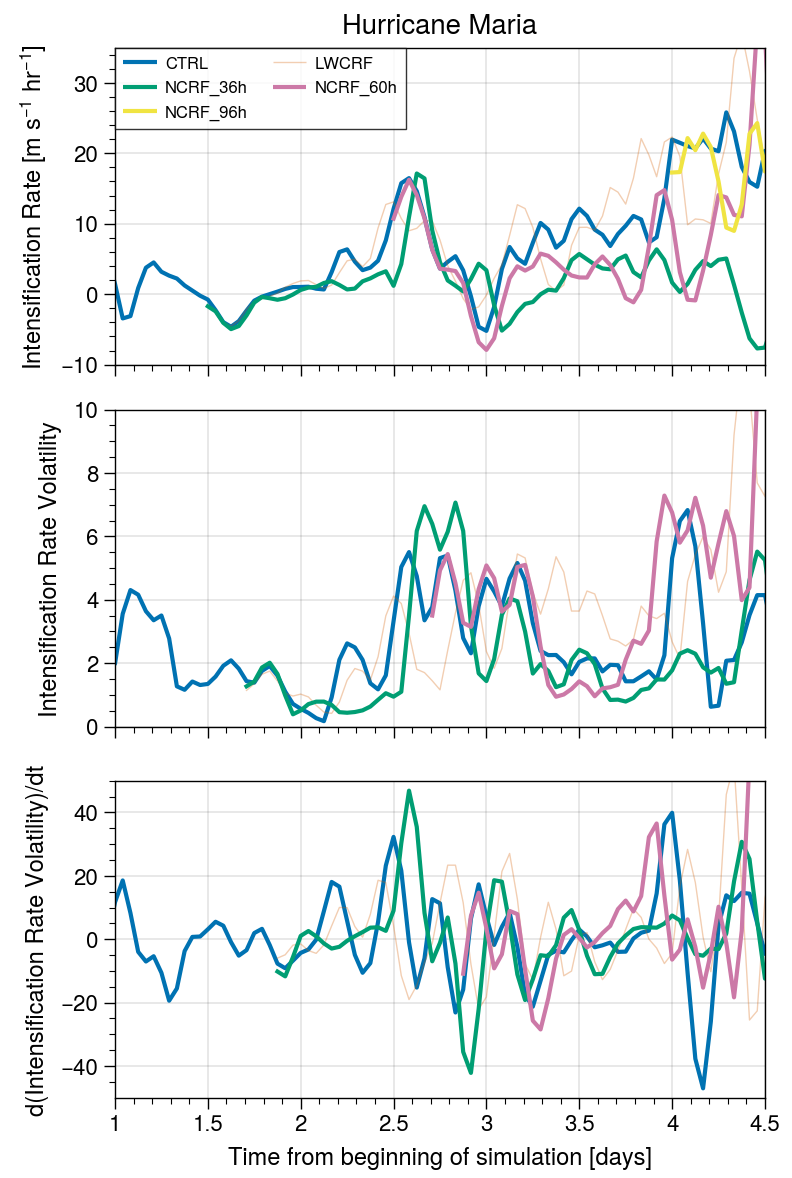

In [19]:
from scipy.ndimage import gaussian_filter
fig,axs = plot.subplots(ncols=1,nrows=3,axwidth=3.25,refaspect=2.051,span=False)
axs[0].plot(ctrl_dict['U'].time/24,np.gradient(smoovtanmax_dict['ctrl'],ctrl_dict['U'].time/24),label='CTRL')
axs[0].plot(lwcrf_dict['U'].time/24+36/24,np.gradient(smoovtanmax_dict['lwcrf'],lwcrf_dict['U'].time/24+36/24),label='LWCRF',alpha=0.3,lw=0.5)
axs[0].plot(ncrf_36h_dict['U'].time/24+36/24,np.gradient(smoovtanmax_dict['ncrf36'],ncrf_36h_dict['U'].time/24+36/24),label='NCRF_36h')
axs[0].plot(ncrf_60h_dict['U'].time/24+60/24,np.gradient(smoovtanmax_dict['ncrf60'],ncrf_60h_dict['U'].time/24+60/24),label='NCRF_60h')
axs[0].plot(ncrf_96h_dict['U'].time/24+96/24,np.gradient(smoovtanmax_dict['ncrf96'],ncrf_96h_dict['U'].time/24+96/24),label='NCRF_96h')
axs[0].format(ylim=[-10,35],xlim=[1,4.5],xlabel='Time from beginning of simulation [days]',\
              ylabel='Intensification Rate [m s$^{-1}$ hr$^{-1}$]',title='Hurricane Maria')#ylim=[-10,25],
axs[0].legend(loc='ul',ncols=2,prop={'size':6})
axs[0].yaxis.label.set_size(8.5)
axs[0].xaxis.label.set_size(8.5)
axs[0].tick_params(axis='both', which='major', labelsize=8)

axs[1].plot(ctrl_dict['U'].time/24,testctrl['CTRL'].rolling(6).std(ddof=1))
axs[1].plot(lwcrf_dict['U'].time/24+36/24,(test_lwcrf['lwcrf'].rolling(6).std(ddof=1)),alpha=0.3,lw=0.5)
axs[1].plot(ncrf_36h_dict['U'].time/24+36/24,test_ncrf36['NCRF_36h'].rolling(6).std(ddof=1))
axs[1].plot(ncrf_60h_dict['U'].time/24+60/24,test_ncrf60['NCRF_60h'].rolling(6).std(ddof=1))
#axs[0].plot(ctrl_dict['U'].time/24,np.gradient(smoovtanmax_dict['ctrl'],ctrl_dict['U'].time/24),label='CTRL')
axs[1].format(xlim=[1,4.5],ylim=[0,10],xlabel='Time from beginning of simulation [days]',
             ylabel='Intensification Rate Volatility')
#axs[0].legend(loc='ul',ncols=2,prop={'size':6})
axs[1].yaxis.label.set_size(8.5)
axs[1].xaxis.label.set_size(8.5)
axs[1].tick_params(axis='both', which='major', labelsize=8)

axs[2].plot(ctrl_dict['U'].time/24,
            gaussian_filter(np.gradient(testctrl['CTRL'].rolling(6).std(ddof=1),ctrl_dict['U'].time/24),0.8))
axs[2].plot(lwcrf_dict['U'].time/24+36/24,
            gaussian_filter(np.gradient(test_lwcrf['lwcrf'].rolling(6).std(ddof=1),lwcrf_dict['U'].time/24+36/24),0.8),alpha=0.3,lw=0.5)
axs[2].plot(ncrf_36h_dict['U'].time/24+36/24,
            gaussian_filter(np.gradient(test_ncrf36['NCRF_36h'].rolling(6).std(ddof=1),ncrf_36h_dict['U'].time/24+36/24),0.8))
axs[2].plot(ncrf_60h_dict['U'].time/24+60/24,
            gaussian_filter(np.gradient(test_ncrf60['NCRF_60h'].rolling(6).std(ddof=1),ncrf_60h_dict['U'].time/24+60/24),0.8))
axs[2].format(xlim=[1,4.5],ylim=[-50,50],xlabel='Time from beginning of simulation [days]',
             ylabel='d(Intensification Rate Volatility)/dt')
axs[2].yaxis.label.set_size(8.5)
axs[2].xaxis.label.set_size(8.5)
axs[2].tick_params(axis='both', which='major', labelsize=8)

plt.show()

In [20]:
time2_ctrl,time45_ctrl = nearest_index(ctrl_dict['U'].time/24, 2),nearest_index(ctrl_dict['U'].time/24, 4.5)
time2_ncrf36,time45_ncrf36 = nearest_index(ncrf_36h_dict['U'].time/24+36/24, 2),nearest_index(ncrf_36h_dict['U'].time/24+36/24, 4.5)
time2_ncrf60,time45_ncrf60 = nearest_index(ncrf_60h_dict['U'].time/24+60/24, 2),nearest_index(ncrf_60h_dict['U'].time/24+60/24, 4.5)

In [21]:
intest_ctrl = gaussian_filter(np.gradient(testctrl['CTRL'].rolling(6).std(ddof=1),ctrl_dict['U'].time/24),0.8)[time2_ctrl:time45_ctrl]
intest_ncrf36 = gaussian_filter(np.gradient(test_ncrf36['NCRF_36h'].rolling(6).std(ddof=1),ncrf_36h_dict['U'].time/24+36/24),0.8)[time2_ncrf36:time45_ncrf36]
intest_ncrf60 = gaussian_filter(np.gradient(test_ncrf60['NCRF_60h'].rolling(6).std(ddof=1),ncrf_60h_dict['U'].time/24+60/24),0.8)[time2_ncrf60:time45_ncrf60]

from scipy.signal import find_peaks
print(find_peaks(intest_ctrl,distance=6))

(array([ 4, 12, 23, 36, 48, 57]), {})


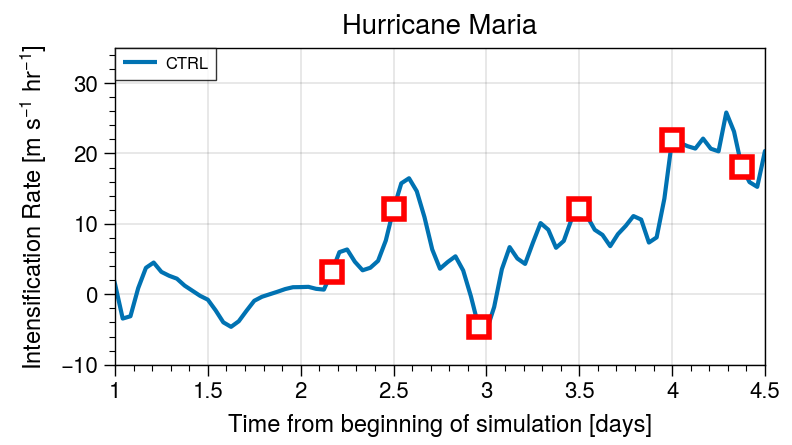

In [30]:
fig,axs = plot.subplots(ncols=1,nrows=1,axwidth=3.25,refaspect=2.051,span=False)
axs[0].plot(ctrl_dict['U'].time/24,np.gradient(smoovtanmax_dict['ctrl'],ctrl_dict['U'].time/24),label='CTRL')
axs[0].plot((ctrl_dict['U'].time[time2_ctrl:time45_ctrl]/24)[find_peaks(intest_ctrl,distance=6)[0]],
         np.gradient(smoovtanmax_dict['ctrl'],ctrl_dict['U'].time/24)[time2_ctrl:time45_ctrl][find_peaks(intest_ctrl,distance=6)[0]],
         lw=0,marker='s',ms=7,mec='r',mfc='w',mew=2)
axs[0].format(ylim=[-10,35],xlim=[1,4.5],xlabel='Time from beginning of simulation [days]',\
              ylabel='Intensification Rate [m s$^{-1}$ hr$^{-1}$]',title='Hurricane Maria')#ylim=[-10,25],
axs[0].legend(loc='ul',ncols=2,prop={'size':6})
axs[0].yaxis.label.set_size(8.5)
axs[0].xaxis.label.set_size(8.5)
axs[0].tick_params(axis='both', which='major', labelsize=8)
plt.show()

##### How much time steps are there with higher intensification rates before Maria reaches Cat.1 intensity?

In [11]:
# Six hour window smoothing
smoo_vtanmax = uniform_filter1d(Vtan_max,12)
# First index Maria reaches Cat 1 strength
indx_cat1=np.abs(uniform_filter1d(Vtan_max,12)-35).argmin()
# Remove weakening time steps
from copy import deepcopy
inten_rate_noweak = deepcopy(np.gradient(smoo_vtanmax,dataU.time/24)[:indx_cat1])
inten_rate_noweak[inten_rate_noweak<0] = np.nan
np.nanpercentile(inten_rate_noweak, [50,75,85,90])

array([ 7.9659462 , 12.27254677, 19.81059265, 20.64978333])

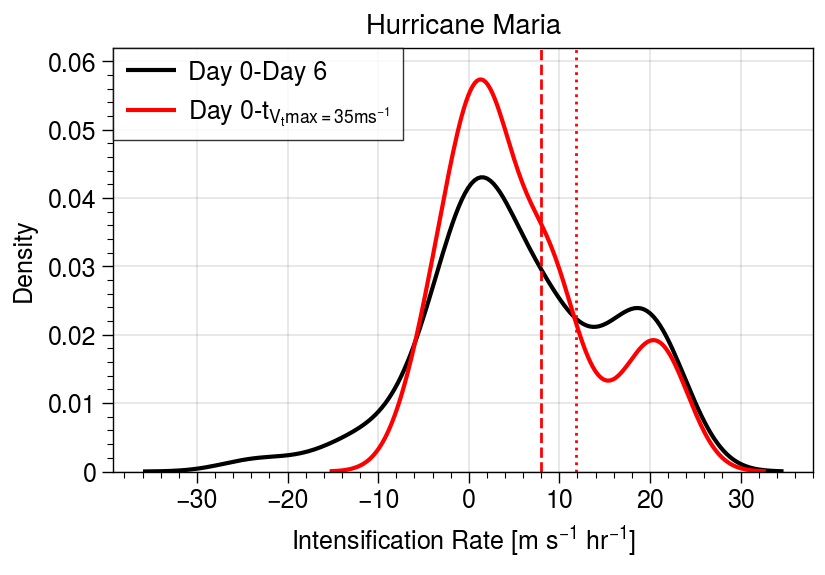

In [12]:
fig,axs = plot.subplots(ncols=1,nrows=1,axwidth=3.5,refaspect=1.651,span=False)
sns.kdeplot(np.gradient(smoo_vtanmax,dataU.time/24)[:],color='k',ax=axs[0],label='Day 0-Day 6')
sns.kdeplot(np.gradient(smoo_vtanmax,dataU.time/24)[:indx_cat1],color='r',ax=axs[0],label='Day 0-$t_{V_tmax=35 m s^{-1}}$')
axs[0].plot([np.nanpercentile(inten_rate_noweak,50),np.nanpercentile(inten_rate_noweak,50)],[0,0.062],color='r',lw=1,ls='--')
axs[0].plot([np.nanpercentile(inten_rate_noweak,74),np.nanpercentile(inten_rate_noweak,74)],[0,0.062],color='r',lw=1,ls='dotted')
axs[0].format(xlabel='Intensification Rate [m s$^{-1}$ hr$^{-1}$]',title='Hurricane Maria',ylim=[0,0.062])
axs[0].legend(loc='ul',ncols=1)
plt.show()

##### Can we find the indices of these time steps?

In [13]:
indices_high,indices_low = [],[]
for indx,obj in enumerate(inten_rate_noweak):
    # High IR
    if obj>np.nanpercentile(inten_rate_noweak,74):
        indices_high.append(indx)
    elif (obj<np.nanpercentile(inten_rate_noweak,50)) & (obj>0):
        indices_low.append(indx)
    else:
        continue

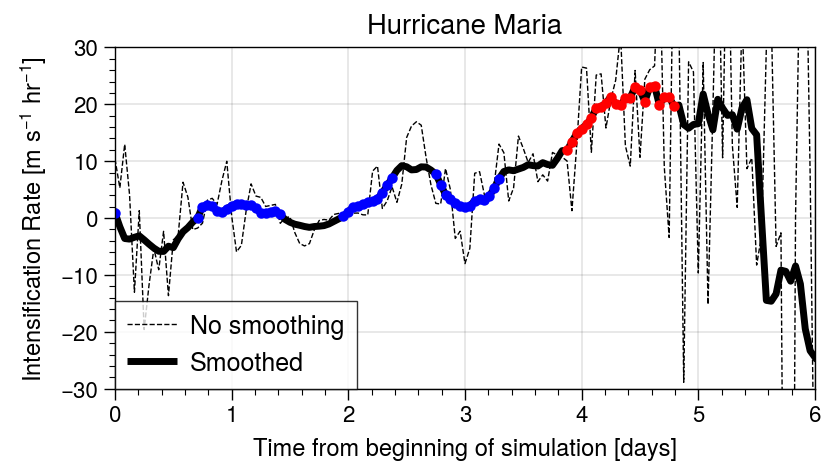

In [14]:
# Six hour window smoothing
smoo_vtanmax = uniform_filter1d(Vtan_max,12)

fig,axs = plot.subplots(ncols=1,nrows=1,axwidth=3.5,refaspect=2.051,span=False)

axs[0].plot(dataU.time/24,np.gradient(Vtan_max,dataU.time/24),color='k',lw=0.5,ls='--',label='No smoothing')
axs[0].plot(dataU.time/24,np.gradient(smoo_vtanmax,dataU.time/24),color='k',lw=2.5,ls='-',label='Smoothed')
axs[0].plot(dataU.time[indices_high]/24,np.gradient(smoo_vtanmax,dataU.time/24)[indices_high],mec='r',
            lw=0,marker='.',ms=5.5,mfc='r')
axs[0].plot(dataU.time[indices_low]/24,np.gradient(smoo_vtanmax,dataU.time/24)[indices_low],mec='b',
            lw=0,marker='.',ms=5.5,mfc='b')
axs[0].format(ylim=[-30,30],xlabel='Time from beginning of simulation [days]',\
              ylabel='Intensification Rate [m s$^{-1}$ hr$^{-1}$]',title='Hurricane Maria')
axs[0].legend(loc='ll',ncols=1)
axs[0].yaxis.label.set_size(8.5)
axs[0].xaxis.label.set_size(8.5)
axs[0].tick_params(axis='both', which='major', labelsize=8)
plt.show()

##### Save time indices

In [16]:
import json,pickle
def save_to_pickle(loc=None,var=None):
    with open(loc,"wb") as f:
        pickle.dump(var,f)
    return None

!mkdir output
save_to_pickle(loc='./output/highir_indx_maria',var=indices_high)
save_to_pickle(loc='./output/lowir_indx_maria',var=indices_low)

mkdir: cannot create directory 'output': File exists


### Check what variables are available 

In [22]:
!find /scratch/06040/tg853394/tc/output/redux/maria/ctl/ -maxdepth 1 -name "azim*" -print

/scratch/06040/tg853394/tc/output/redux/maria/ctl/azim_RTHRATSWC_0-144hr.nc
/scratch/06040/tg853394/tc/output/redux/maria/ctl/azim_RTHRATLWC_0-144hr.nc
/scratch/06040/tg853394/tc/output/redux/maria/ctl/azim_QVAPOR_0-144hr.nc
/scratch/06040/tg853394/tc/output/redux/maria/ctl/azim_SLP_0-144hr.nc
/scratch/06040/tg853394/tc/output/redux/maria/ctl/azim_rainrate_0-144hr.nc
/scratch/06040/tg853394/tc/output/redux/maria/ctl/azim_OLR_0-144hr.nc
/scratch/06040/tg853394/tc/output/redux/maria/ctl/azim_RTHRATSW_0-144hr.nc
/scratch/06040/tg853394/tc/output/redux/maria/ctl/azim_QICE_0-144hr.nc
/scratch/06040/tg853394/tc/output/redux/maria/ctl/azim_T_0-144hr.nc
/scratch/06040/tg853394/tc/output/redux/maria/ctl/azim_RTHRATLW_0-144hr.nc
/scratch/06040/tg853394/tc/output/redux/maria/ctl/azim_QCLOUD_0-144hr.nc
/scratch/06040/tg853394/tc/output/redux/maria/ctl/azim_AVOR_0-144hr.nc
/scratch/06040/tg853394/tc/output/redux/maria/ctl/azim_LH_0-144hr.nc
/scratch/06040/tg853394/tc/output/redux/maria/ctl/azim_HFX

In [91]:
dataPW = xr.open_dataset('/scratch/06040/tg853394/tc/output/redux/maria/ctl/azim_PW_0-144hr.nc')
dataLWC = xr.open_dataset('/scratch/06040/tg853394/tc/output/redux/maria/ctl/azim_RTHRATLWC_0-144hr.nc')
dataLW = xr.open_dataset('/scratch/06040/tg853394/tc/output/redux/maria/ctl/azim_RTHRATLW_0-144hr.nc')

In [66]:
from metpy.calc import pressure_to_height_std
from metpy.units import units
path_coor = '/scratch/06040/tg853394/tc/output/redux/maria/ctl/post/U.nc'
coor = xr.open_dataset(path_coor)
pressure = units.Quantity(coor.pres.data, 'hPa')
height = np.asarray(pressure_to_height_std(pressure))

In [92]:
int_lwc = np.trapz(dataLWC.RTHRATLWC[:,:,:,:],height,axis=1)
int_infra = np.trapz(dataLWC.RTHRATLWC[:,:,:,:]-dataLW.RTHRATLW[:,:,:,:],height,axis=1)

In [93]:
int_lwcA = np.mean(int_lwc[:,:,:i500],axis=(1,2))
int_infraA = np.mean(int_infra[:,:,:i500],axis=(1,2))

In [94]:
int_lwcdiff = [int_lwc[timeindx,:,:i500]-np.ones((360,167))*(int_lwcA[timeindx]) for timeindx in range(145)]
int_infradiff = [int_infra[timeindx,:,:i500]-np.ones((360,167))*(int_infraA[timeindx]) for timeindx in range(145)]

In [104]:
PWazimax = np.max(np.mean(dataPW.PW[:,0,:,:i500],axis=1),axis=1)
LWCazimax = np.max(np.mean(int_lwc[:,:,:i500],axis=1),axis=1)
infraazimax = np.max(np.mean(np.asarray(int_infradiff),axis=1),axis=1)

PWazimean = np.mean(np.mean(dataPW.PW[:,0,:,:i500],axis=1),axis=1)
LWCazimean = np.mean(np.mean(int_lwc[:,:,:i500],axis=1),axis=1)
infraazimean = np.mean(np.mean(np.asarray(int_infradiff),axis=1),axis=1)

In [29]:
def bivariate(xARRAY=None,yARRAY=None,dotsize=6,kdelw=1.5,dotcolor=None,
              kdecmap='Blues',TYPE='two_plot',xlim=[-15,35],ylim=[58,78],ncols=2,nrows=1,axwidth=2.5,
              refaspect=1.051,xlabel='Intensification Rate [m s$^{-1}$ hr$^{-1}$]',ylabel=None,suptitle='Hurricane Maria',
             indx_cutoff=indx_cat1):
    if TYPE=='two_plot':
        fig,axs = plot.subplots(ncols=ncols,nrows=nrows,axwidth=axwidth,refaspect=refaspect,span=False)
        sns.scatterplot(x=xARRAY,y=yARRAY,ax=axs[0],alpha=0.9,s=6,color=dotcolor)
        sns.kdeplot(x=xARRAY,y=yARRAY, levels=9, cmap=kdecmap,ax=axs[0],lw=kdelw)
        sns.scatterplot(x=xARRAY[:indx_cutoff],y=yARRAY[:indx_cutoff],ax=axs[1],alpha=0.9,s=6,color=dotcolor)
        sns.kdeplot(x=xARRAY[:indx_cutoff],y=yARRAY[:indx_cutoff],levels=9, cmap=kdecmap,ax=axs[1],lw=kdelw)
        axs.format(xlim=xlim,ylim=ylim,xlabel=xlabel,ylabel=ylabel,suptitle=suptitle)
        axs[0].format(title='0 day - 6 day')
        axs[1].format(title='0 day - $t_{V_tmax=35 m s^{-1}}$')
        axs[0].yaxis.label.set_size(8.5)
        axs[0].xaxis.label.set_size(8.5)
        axs[1].xaxis.label.set_size(8.5)
        axs[0].tick_params(axis='both', which='major', labelsize=8)
        axs[1].tick_params(axis='both', which='major', labelsize=8)
        plt.show()
        return None

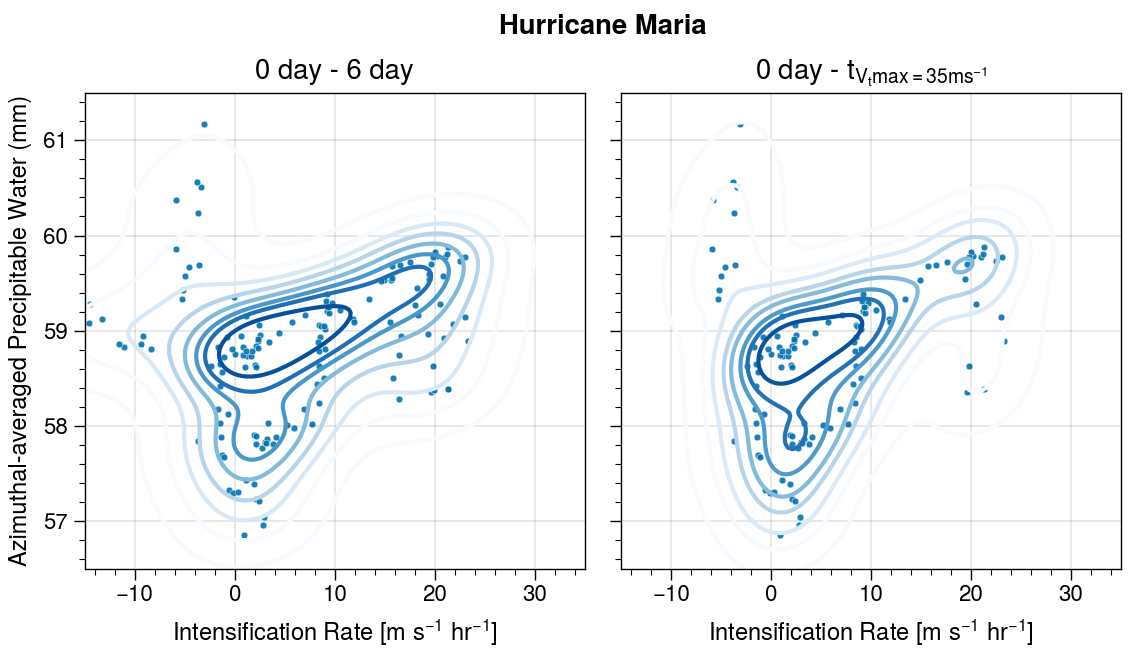

In [26]:
bivariate(xARRAY=np.gradient(smoo_vtanmax,dataU.time/24),yARRAY=PWazimean,dotsize=6,kdelw=1.5,dotcolor='#1f77b4',
          kdecmap='Blues',TYPE='two_plot',xlim=[-15,35],ylim=[56.5,61.5],ncols=2,nrows=1,axwidth=2.5,
          refaspect=1.051,xlabel='Intensification Rate [m s$^{-1}$ hr$^{-1}$]',
          ylabel='Azimuthal-averaged Precipitable Water (mm)',suptitle='Hurricane Maria',indx_cutoff=indx_cat1)

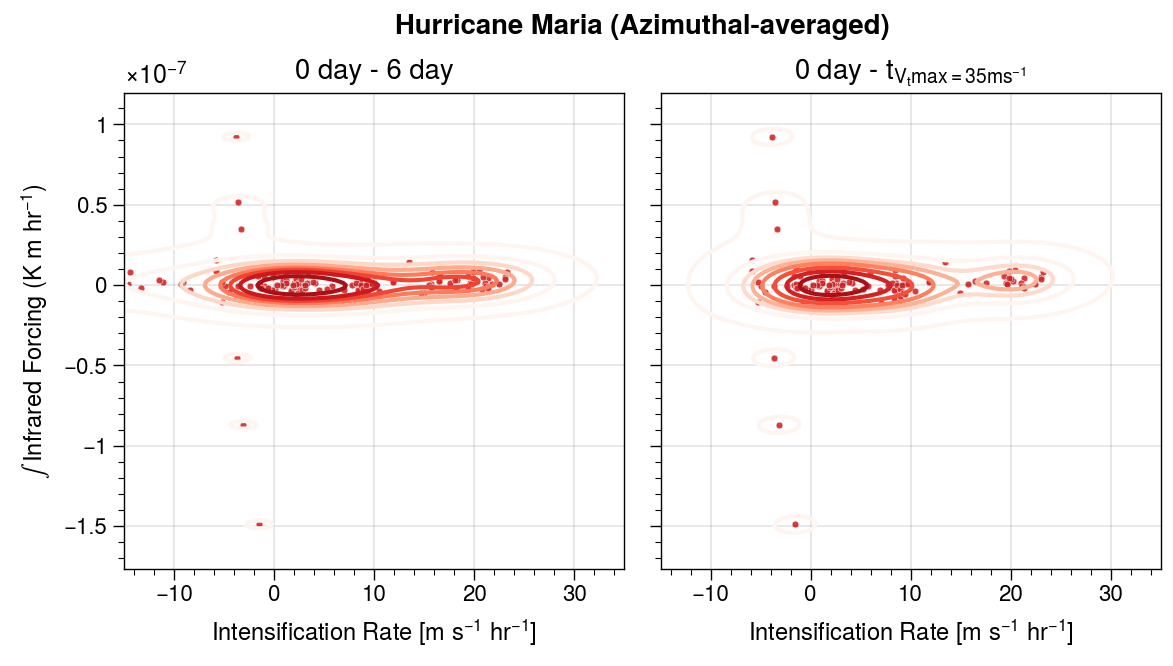

In [105]:
bivariate(xARRAY=np.gradient(smoo_vtanmax,dataU.time/24),yARRAY=(infraazimean)*(60*60),dotsize=6,kdelw=1.5,dotcolor='#d62728',
          kdecmap='Reds',TYPE='two_plot',xlim=[-15,35],ylim=None,ncols=2,nrows=1,axwidth=2.5,
          refaspect=1.051,xlabel='Intensification Rate [m s$^{-1}$ hr$^{-1}$]',
          ylabel=r'$\int$ Infrared Forcing (K m hr$^{-1}$)',suptitle='Hurricane Maria (Azimuthal-averaged)',indx_cutoff=indx_cat1)

#### Composite Analysis

In [82]:
PWper_high,PWper_low = [],[]
for indx,obj in enumerate(indices_high):
    testa_org = deepcopy(dataPW.PW[int(obj),0,:,:i500]-np.mean(np.mean(dataPW.PW[:,0,:,:i500],axis=1),axis=1)[int(obj)])
    PWper_high.append((testa_org-np.mean(testa_org))/np.std(testa_org))
del testa_org

for indx,obj in enumerate(indices_low):
    testa_org = deepcopy(dataPW.PW[int(obj),0,:,:i500]-np.mean(np.mean(dataPW.PW[:,0,:,:i500],axis=1),axis=1)[int(obj)])
    PWper_low.append((testa_org-np.mean(testa_org))/np.std(testa_org))
del testa_org
#TESTb = deepcopy(dataPW.PW[50,0,:,:i500]-np.mean(np.mean(dataPW.PW[:,0,:,:i500],axis=1),axis=1)[50])
#TESTb = (TESTb-np.mean(TESTb))/np.std(TESTb)

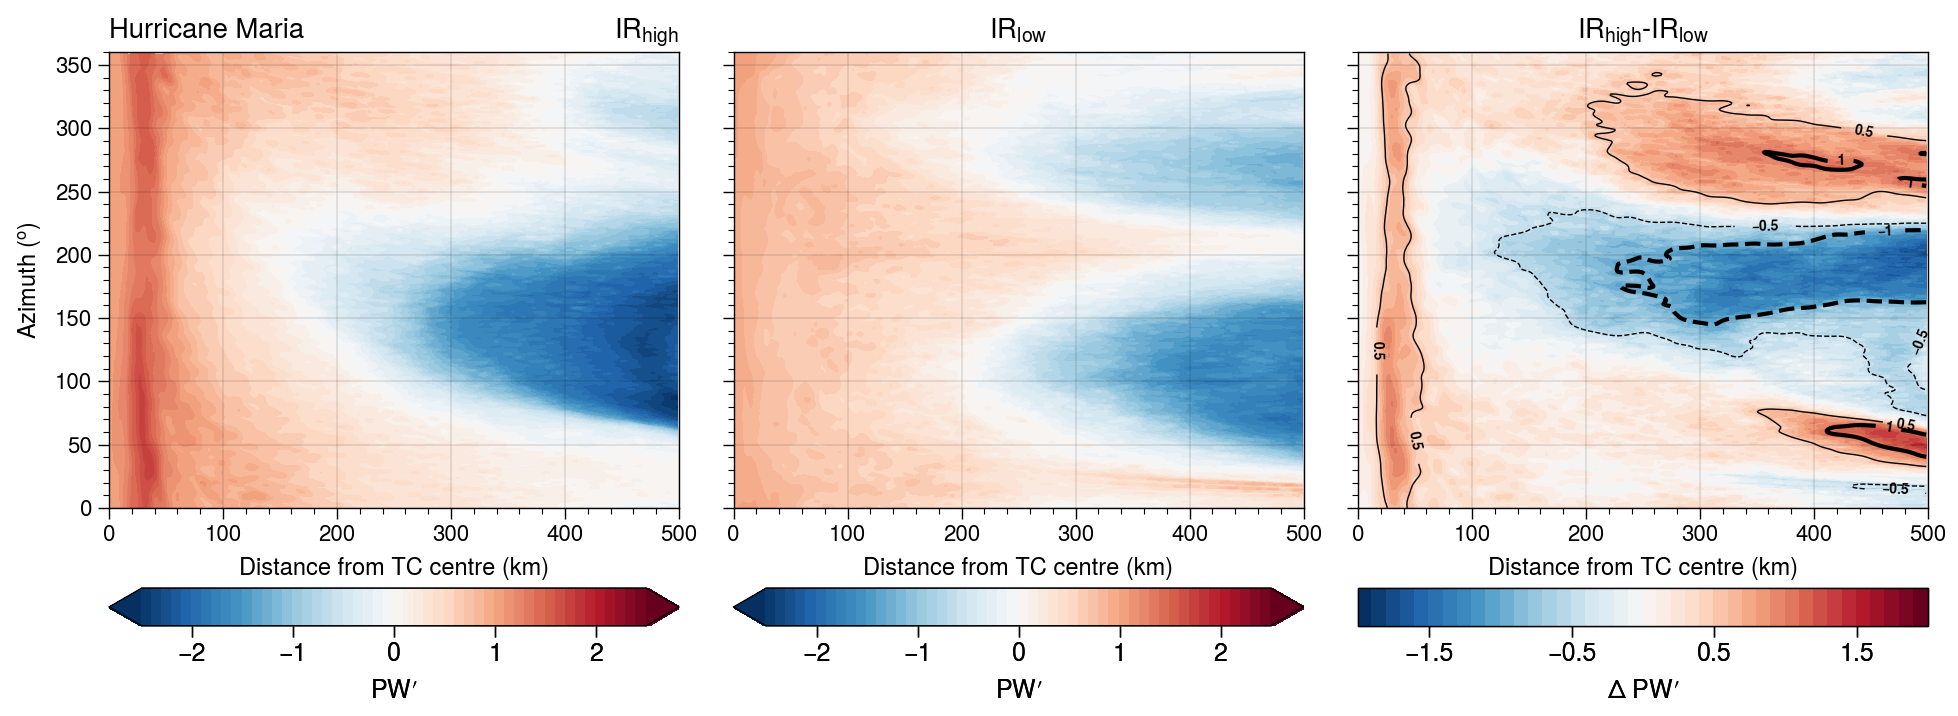

In [83]:
from skimage import filters
PWper_highcmp = np.nanmean(np.asarray(PWper_high),axis=0)
PWper_lowcmp = np.nanmean(np.asarray(PWper_low),axis=0)
#img=plt.pcolormesh(dataPW.radius[:i500],dataPW.azmiuth,\
#                   PWper_highcmp,cmap='RdBu_r',vmin=-3,vmax=3)
fig,axs = plot.subplots(ncols=3,nrows=1,axwidth=2.85,refaspect=1.251,span=False)
img=axs[0].contourf(dataPW.radius[:i500],dataPW.azmiuth,PWper_highcmp,cmap='RdBu_r',
                    levels=np.linspace(-2.5,2.5,51),extend='both')
axs[0].colorbar(img,ticks=[-2,-1,0,1,2],label=r'PW$\prime$',loc='b')
axs[0].format(xlim=[0,500],ylim=[0,360],xlabel='Distance from TC centre (km)',ltitle='Hurricane Maria',rtitle='IR$_{high}$')
img=axs[1].contourf(dataPW.radius[:i500],dataPW.azmiuth,PWper_lowcmp,cmap='RdBu_r',
                    levels=np.linspace(-2.5,2.5,51),extend='both')
axs[1].colorbar(img,ticks=[-2,-1,0,1,2],label=r'PW$\prime$',loc='b')
axs[1].format(xlim=[0,500],ylim=[0,360],xlabel='Distance from TC centre (km)',title='IR$_{low}$')
img=axs[2].contourf(dataPW.radius[:i500],dataPW.azmiuth,PWper_highcmp-PWper_lowcmp,cmap='RdBu_r',
                    levels=np.linspace(-2,2,41))
axs[2].contour(dataPW.radius[:i500],dataPW.azmiuth,filters.gaussian(PWper_highcmp-PWper_lowcmp,2),color='k',
                    levels=[0.5,1],lw=[0.5,1.5],labels=True, precision=1, labels_kw={'weight': 'bold','size':5})
axs[2].contour(dataPW.radius[:i500],dataPW.azmiuth,filters.gaussian(PWper_highcmp-PWper_lowcmp,2),color='k',ls='--',
                    levels=[-1,-0.5],lw=[1.5,0.5],labels=True, precision=1, labels_kw={'weight': 'bold','size':5})
axs[2].colorbar(img,ticks=[-1.5,-0.5,0.5,1.5],label=r'$\Delta$ PW$\prime$',loc='b')
axs[2].format(xlim=[0,500],ylim=[0,360],xlabel='Distance from TC centre (km)',\
          ylabel='Azimuth ($^{o}$)',title='IR$_{high}$-IR$_{low}$')
for axisobj in axs:
    axisobj.yaxis.label.set_size(8.5)
    axisobj.xaxis.label.set_size(8.5)
    axisobj.tick_params(axis='both', which='major', labelsize=8)
plt.show()

### OLR

In [84]:
dataOLR = xr.open_dataset('/scratch/06040/tg853394/tc/output/redux/maria/ctl/azim_OLR_0-144hr.nc')

OLRper_high,OLRper_low = [],[]
for indx,obj in enumerate(indices_high):
    testa_org = deepcopy(dataOLR.OLR[int(obj),0,:,:i500]-np.mean(np.mean(dataOLR.OLR[:,0,:,:i500],axis=1),axis=1)[int(obj)])
    OLRper_high.append((testa_org-np.mean(testa_org))/np.std(testa_org))
del testa_org

for indx,obj in enumerate(indices_low):
    testa_org = deepcopy(dataOLR.OLR[int(obj),0,:,:i500]-np.mean(np.mean(dataOLR.OLR[:,0,:,:i500],axis=1),axis=1)[int(obj)])
    OLRper_low.append((testa_org-np.mean(testa_org))/np.std(testa_org))
del testa_org

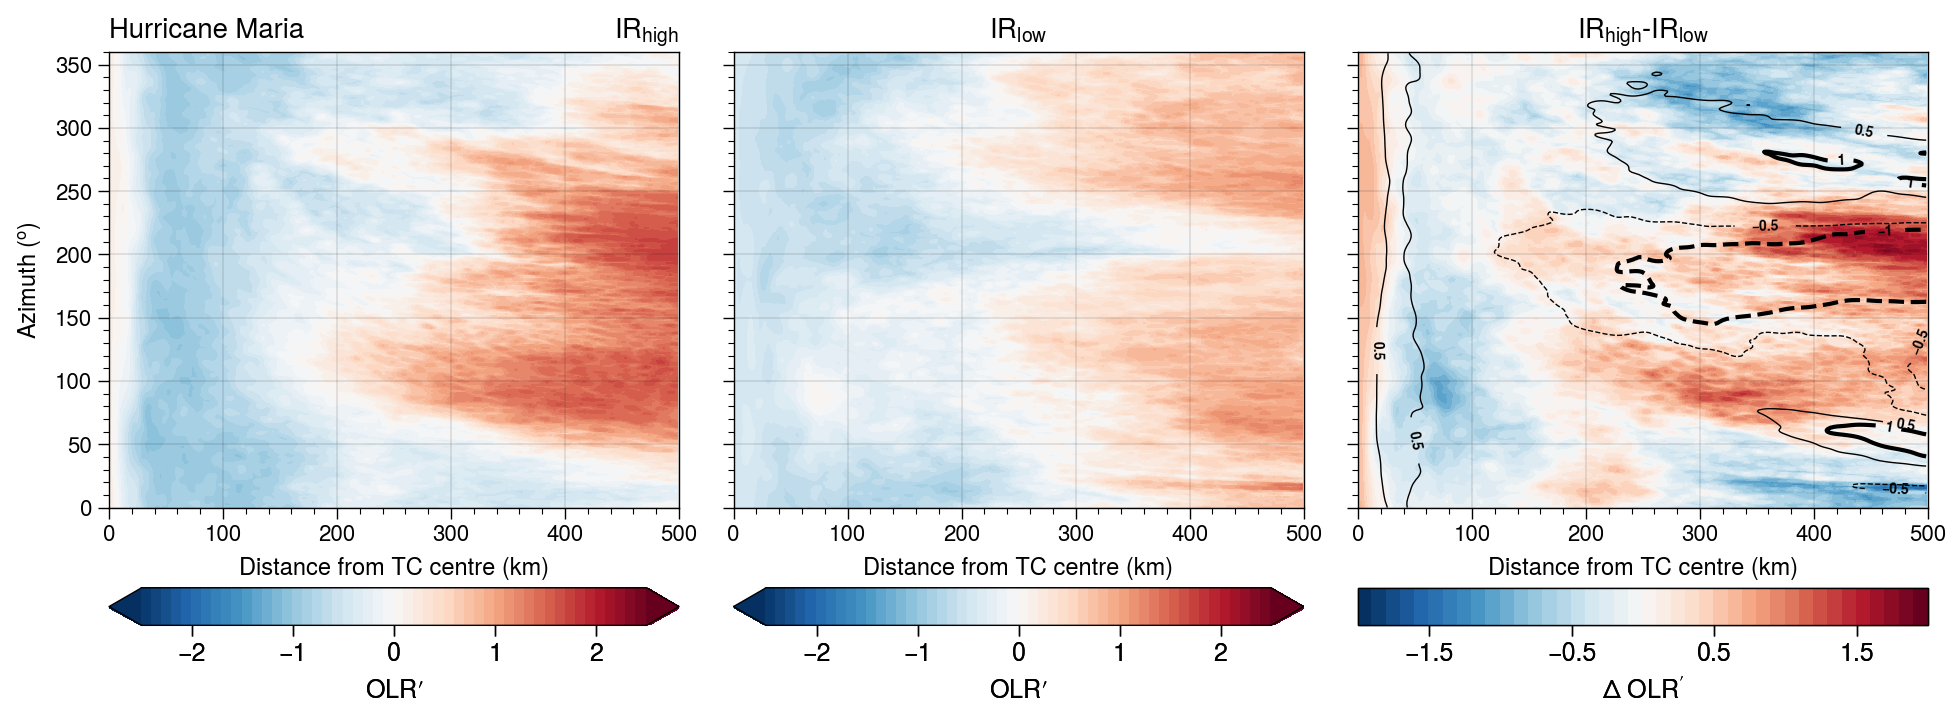

In [85]:
OLRper_highcmp = np.nanmean(np.asarray(OLRper_high),axis=0)
OLRper_lowcmp = np.nanmean(np.asarray(OLRper_low),axis=0)
#img=plt.pcolormesh(dataPW.radius[:i500],dataPW.azmiuth,\
#                   PWper_highcmp,cmap='RdBu_r',vmin=-3,vmax=3)
fig,axs = plot.subplots(ncols=3,nrows=1,axwidth=2.85,refaspect=1.251,span=False)
img=axs[0].contourf(dataOLR.radius[:i500],dataOLR.azmiuth,OLRper_highcmp,cmap='RdBu_r',
                    levels=np.linspace(-2.5,2.5,51),extend='both')
axs[0].colorbar(img,ticks=[-2,-1,0,1,2],label=r'OLR$\prime$',loc='b')
axs[0].format(xlim=[0,500],ylim=[0,360],xlabel='Distance from TC centre (km)',ltitle='Hurricane Maria',rtitle='IR$_{high}$')
img=axs[1].contourf(dataOLR.radius[:i500],dataOLR.azmiuth,OLRper_lowcmp,cmap='RdBu_r',
                    levels=np.linspace(-2.5,2.5,51),extend='both')
axs[1].colorbar(img,ticks=[-2,-1,0,1,2],label=r'OLR$\prime$',loc='b')
axs[1].format(xlim=[0,500],ylim=[0,360],xlabel='Distance from TC centre (km)',title='IR$_{low}$')
img=axs[2].contourf(dataOLR.radius[:i500],dataOLR.azmiuth,OLRper_highcmp-OLRper_lowcmp,cmap='RdBu_r',
                    levels=np.linspace(-2,2,41))
axs[2].contour(dataPW.radius[:i500],dataPW.azmiuth,filters.gaussian(PWper_highcmp-PWper_lowcmp,2),color='k',
                    levels=[0.5,1],lw=[0.5,1.5],labels=True, precision=1, labels_kw={'weight': 'bold','size':5})
axs[2].contour(dataPW.radius[:i500],dataPW.azmiuth,filters.gaussian(PWper_highcmp-PWper_lowcmp,2),color='k',ls='--',
                    levels=[-1,-0.5],lw=[1.5,0.5],labels=True, precision=1, labels_kw={'weight': 'bold','size':5})
axs[2].colorbar(img,ticks=[-1.5,-0.5,0.5,1.5],label=r'$\Delta$ $OLR^\prime$',loc='b')
axs[2].format(xlim=[0,500],ylim=[0,360],xlabel='Distance from TC centre (km)',\
          ylabel='Azimuth ($^{o}$)',title='IR$_{high}$-IR$_{low}$')
for axisobj in axs:
    axisobj.yaxis.label.set_size(8.5)
    axisobj.xaxis.label.set_size(8.5)
    axisobj.tick_params(axis='both', which='major', labelsize=8)
plt.show()

#### Radial velocity

In [86]:
Uradper_high,Uradper_low = [],[]
for indx,obj in enumerate(indices_high):
    testa_org = deepcopy(Urad[int(obj),0,:,:i500]-np.mean(np.mean(Urad[:,0,:,:i500],axis=1),axis=1)[int(obj)])
    Uradper_high.append((testa_org-np.mean(testa_org))/np.std(testa_org))
del testa_org

for indx,obj in enumerate(indices_low):
    testa_org = deepcopy(Urad[int(obj),0,:,:i500]-np.mean(np.mean(Urad[:,0,:,:i500],axis=1),axis=1)[int(obj)])
    Uradper_low.append((testa_org-np.mean(testa_org))/np.std(testa_org))
del testa_org

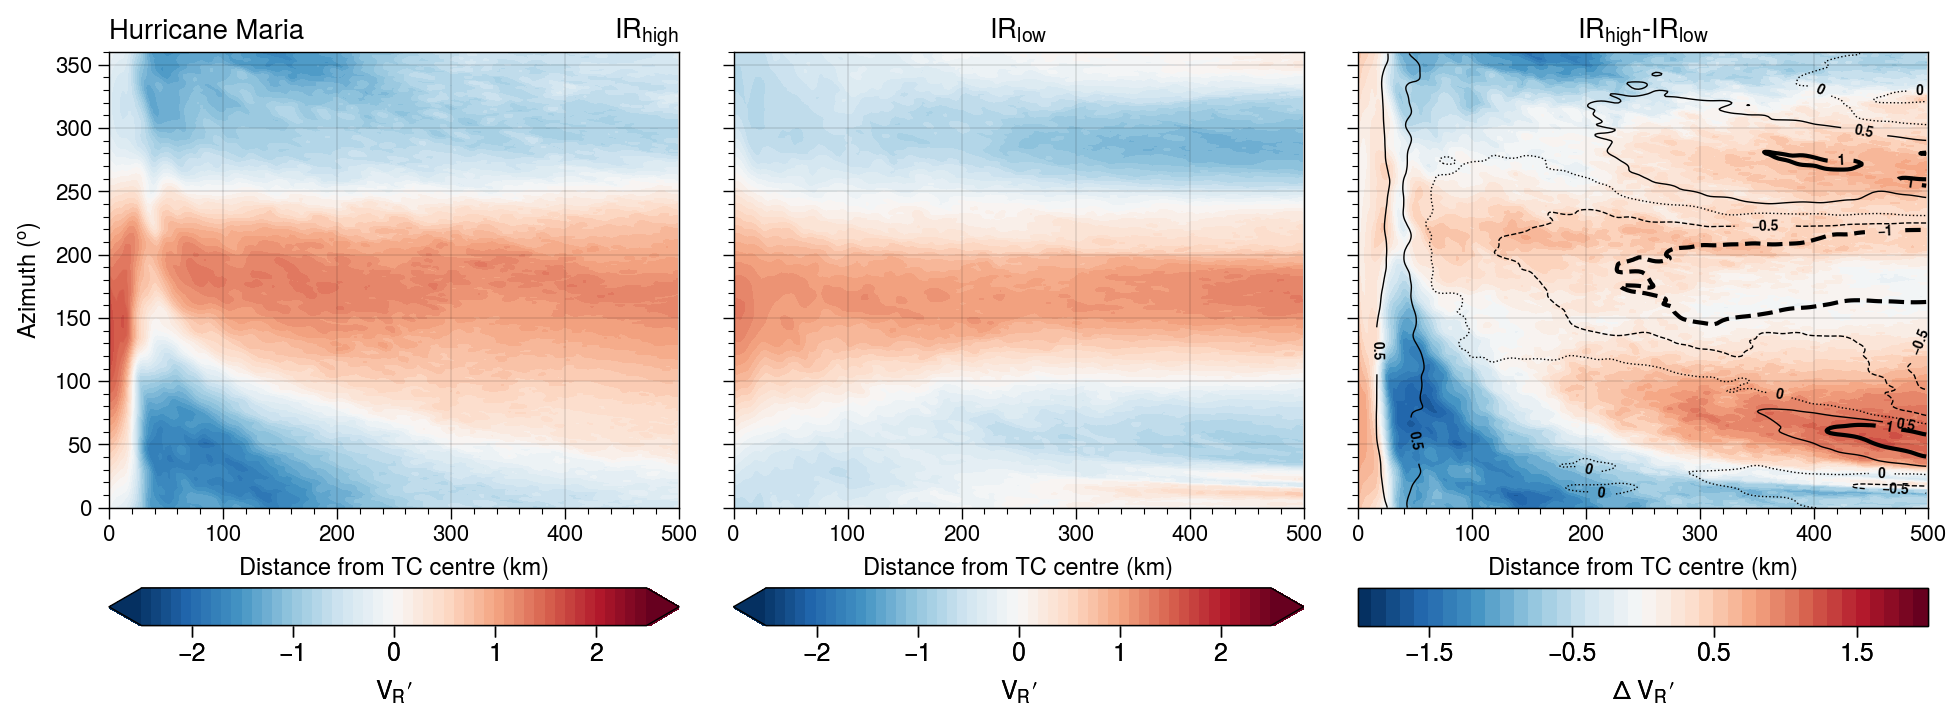

In [87]:
Uradper_highcmp = np.nanmean(np.asarray(Uradper_high),axis=0)
Uradper_lowcmp = np.nanmean(np.asarray(Uradper_low),axis=0)

fig,axs = plot.subplots(ncols=3,nrows=1,axwidth=2.85,refaspect=1.251,span=False)
img=axs[0].contourf(dataOLR.radius[:i500],dataOLR.azmiuth,Uradper_highcmp,cmap='RdBu_r',
                    levels=np.linspace(-2.5,2.5,51),extend='both')
axs[0].colorbar(img,ticks=[-2,-1,0,1,2],label=r'V$_{R}$$\prime$',loc='b')
axs[0].format(xlim=[0,500],ylim=[0,360],xlabel='Distance from TC centre (km)',ltitle='Hurricane Maria',rtitle='IR$_{high}$')
img=axs[1].contourf(dataOLR.radius[:i500],dataOLR.azmiuth,Uradper_lowcmp,cmap='RdBu_r',
                    levels=np.linspace(-2.5,2.5,51),extend='both')
axs[1].colorbar(img,ticks=[-2,-1,0,1,2],label=r'V$_{R}$$\prime$',loc='b')
axs[1].format(xlim=[0,500],ylim=[0,360],xlabel='Distance from TC centre (km)',title='IR$_{low}$')
img=axs[2].contourf(dataOLR.radius[:i500],dataOLR.azmiuth,Uradper_highcmp-Uradper_lowcmp,cmap='RdBu_r',
                    levels=np.linspace(-2,2,41))
axs[2].contour(dataPW.radius[:i500],dataPW.azmiuth,filters.gaussian(PWper_highcmp-PWper_lowcmp,2),color='k',
                    levels=[0.5,1],lw=[0.5,1.5],labels=True, precision=1, labels_kw={'weight': 'bold','size':5})
axs[2].contour(dataPW.radius[:i500],dataPW.azmiuth,filters.gaussian(PWper_highcmp-PWper_lowcmp,2),color='k',ls='--',
                    levels=[-1,-0.5],lw=[1.5,0.5],labels=True, precision=1, labels_kw={'weight': 'bold','size':5})
axs[2].contour(dataPW.radius[:i500],dataPW.azmiuth,filters.gaussian(PWper_highcmp-PWper_lowcmp,2),color='k',ls='dotted',
                    levels=[0],lw=[0.5],labels=True, precision=1, labels_kw={'weight': 'bold','size':5})
axs[2].colorbar(img,ticks=[-1.5,-0.5,0.5,1.5],label=r'$\Delta$ V$_{R}$$\prime$',loc='b')
axs[2].format(xlim=[0,500],ylim=[0,360],xlabel='Distance from TC centre (km)',\
          ylabel='Azimuth ($^{o}$)',title='IR$_{high}$-IR$_{low}$')
for axisobj in axs:
    axisobj.yaxis.label.set_size(8.5)
    axisobj.xaxis.label.set_size(8.5)
    axisobj.tick_params(axis='both', which='major', labelsize=8)
plt.show()

In [88]:
RATLWCper_high,RATLWCper_low = [],[]
for indx,obj in enumerate(indices_high):
    testa_org = deepcopy(dataLWC.RTHRATLWC[int(obj),0,:,:i500]-np.mean(np.mean(dataLWC.RTHRATLWC[:,0,:,:i500],axis=1),axis=1)[int(obj)])
    RATLWCper_high.append((testa_org-np.mean(testa_org))/np.std(testa_org))
del testa_org

for indx,obj in enumerate(indices_low):
    testa_org = deepcopy(dataLWC.RTHRATLWC[int(obj),0,:,:i500]-np.mean(np.mean(dataLWC.RTHRATLWC[:,0,:,:i500],axis=1),axis=1)[int(obj)])
    RATLWCper_low.append((testa_org-np.mean(testa_org))/np.std(testa_org))
del testa_org

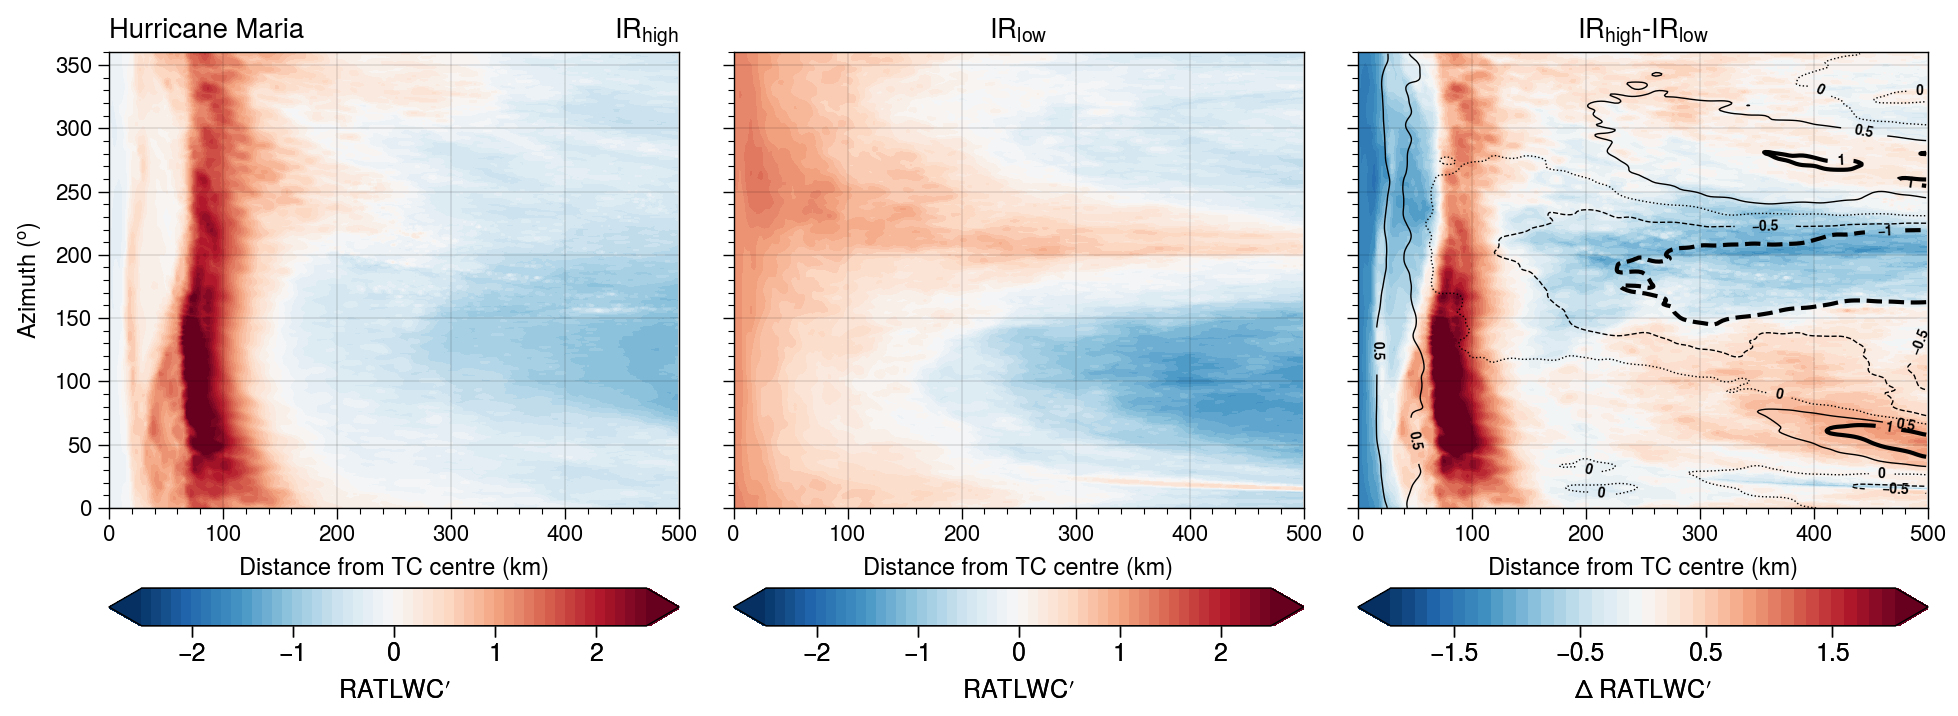

In [90]:
RATLWCper_highcmp = np.nanmean(np.asarray(RATLWCper_high),axis=0)
RATLWCper_lowcmp = np.nanmean(np.asarray(RATLWCper_low),axis=0)

fig,axs = plot.subplots(ncols=3,nrows=1,axwidth=2.85,refaspect=1.251,span=False)
img=axs[0].contourf(dataOLR.radius[:i500],dataOLR.azmiuth,RATLWCper_highcmp,cmap='RdBu_r',
                    levels=np.linspace(-2.5,2.5,51),extend='both')
axs[0].colorbar(img,ticks=[-2,-1,0,1,2],label=r'RATLWC$\prime$',loc='b')
axs[0].format(xlim=[0,500],ylim=[0,360],xlabel='Distance from TC centre (km)',ltitle='Hurricane Maria',rtitle='IR$_{high}$')
img=axs[1].contourf(dataOLR.radius[:i500],dataOLR.azmiuth,RATLWCper_lowcmp,cmap='RdBu_r',
                    levels=np.linspace(-2.5,2.5,51),extend='both')
axs[1].colorbar(img,ticks=[-2,-1,0,1,2],label=r'RATLWC$\prime$',loc='b')
axs[1].format(xlim=[0,500],ylim=[0,360],xlabel='Distance from TC centre (km)',title='IR$_{low}$')
img=axs[2].contourf(dataOLR.radius[:i500],dataOLR.azmiuth,RATLWCper_highcmp-RATLWCper_lowcmp,cmap='RdBu_r',
                    levels=np.linspace(-2,2,41),extend='both')
axs[2].contour(dataPW.radius[:i500],dataPW.azmiuth,filters.gaussian(PWper_highcmp-PWper_lowcmp,2),color='k',
                    levels=[0.5,1],lw=[0.5,1.5],labels=True, precision=1, labels_kw={'weight': 'bold','size':5})
axs[2].contour(dataPW.radius[:i500],dataPW.azmiuth,filters.gaussian(PWper_highcmp-PWper_lowcmp,2),color='k',ls='--',
                    levels=[-1,-0.5],lw=[1.5,0.5],labels=True, precision=1, labels_kw={'weight': 'bold','size':5})
axs[2].contour(dataPW.radius[:i500],dataPW.azmiuth,filters.gaussian(PWper_highcmp-PWper_lowcmp,2),color='k',ls='dotted',
                    levels=[0],lw=[0.5],labels=True, precision=1, labels_kw={'weight': 'bold','size':5})
axs[2].colorbar(img,ticks=[-1.5,-0.5,0.5,1.5],label=r'$\Delta$ RATLWC$\prime$',loc='b')
axs[2].format(xlim=[0,500],ylim=[0,360],xlabel='Distance from TC centre (km)',\
          ylabel='Azimuth ($^{o}$)',title='IR$_{high}$-IR$_{low}$')
for axisobj in axs:
    axisobj.yaxis.label.set_size(8.5)
    axisobj.xaxis.label.set_size(8.5)
    axisobj.tick_params(axis='both', which='major', labelsize=8)
plt.show()

In [107]:
int_infra
INFRAper_high,INFRAper_low = [],[]
for indx,obj in enumerate(indices_high):
    testa_org = deepcopy(int_infra[int(obj),:,:i500]-np.mean(np.mean(int_infra[:,:,:i500],axis=1),axis=1)[int(obj)])
    INFRAper_high.append((testa_org-np.mean(testa_org))/np.std(testa_org))
del testa_org

for indx,obj in enumerate(indices_low):
    testa_org = deepcopy(int_infra[int(obj),:,:i500]-np.mean(np.mean(int_infra[:,:,:i500],axis=1),axis=1)[int(obj)])
    INFRAper_low.append((testa_org-np.mean(testa_org))/np.std(testa_org))
del testa_org

/tmp/ipykernel_163968/2454395287.py:10: RuntimeWarning: invalid value encountered in true_divide
  INFRAper_low.append((testa_org-np.mean(testa_org))/np.std(testa_org))


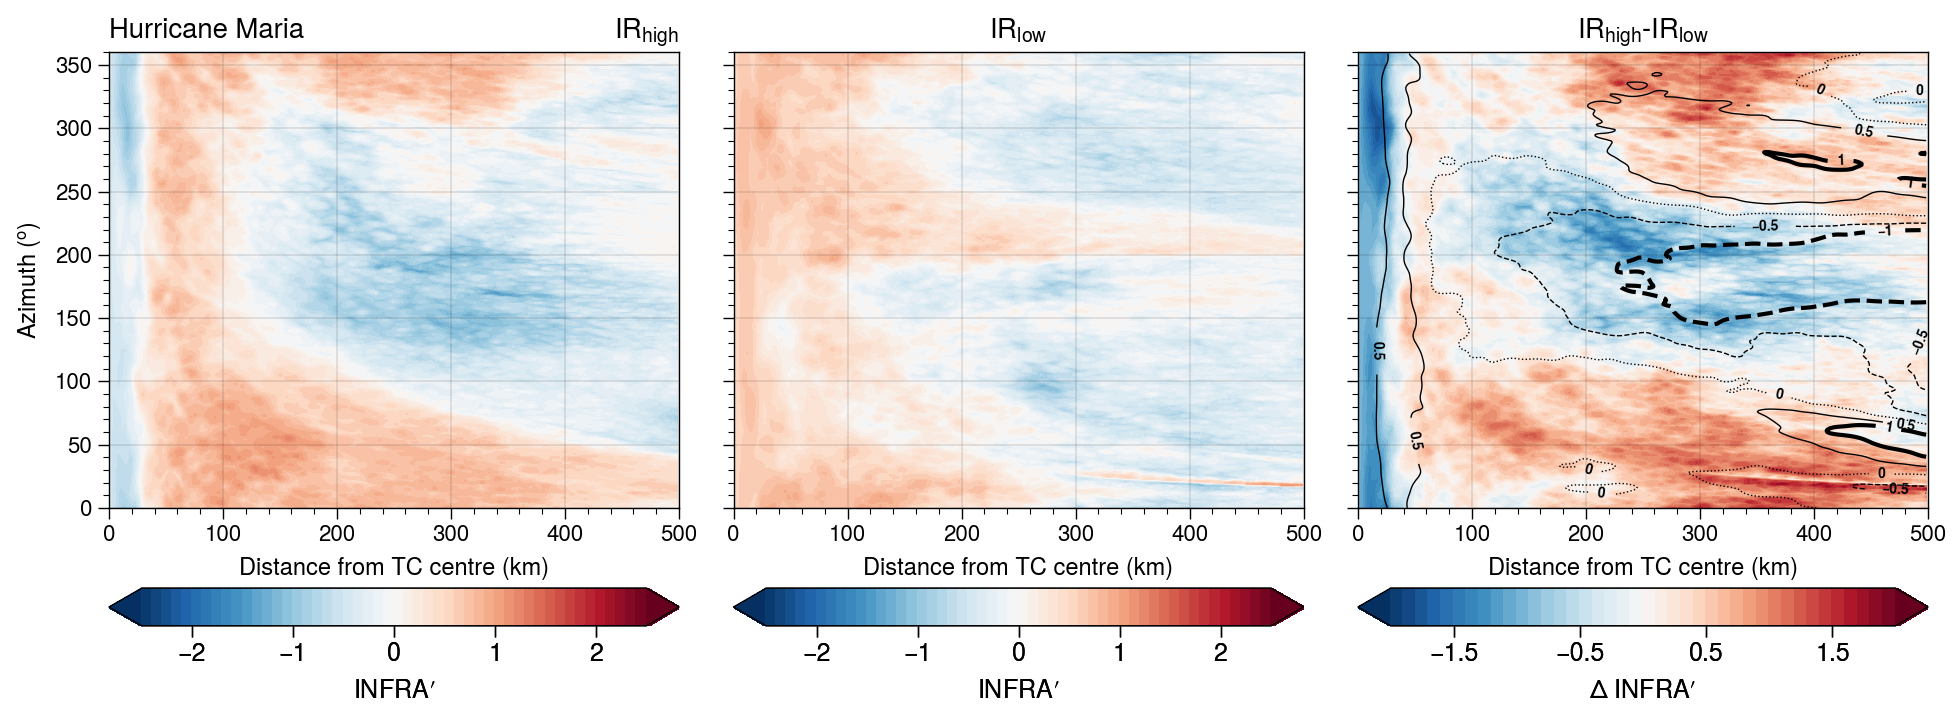

In [108]:
INFRAper_highcmp = np.nanmean(np.asarray(INFRAper_high),axis=0)
INFRAper_lowcmp = np.nanmean(np.asarray(INFRAper_low),axis=0)

fig,axs = plot.subplots(ncols=3,nrows=1,axwidth=2.85,refaspect=1.251,span=False)
img=axs[0].contourf(dataOLR.radius[:i500],dataOLR.azmiuth,INFRAper_highcmp,cmap='RdBu_r',
                    levels=np.linspace(-2.5,2.5,51),extend='both')
axs[0].colorbar(img,ticks=[-2,-1,0,1,2],label=r'INFRA$\prime$',loc='b')
axs[0].format(xlim=[0,500],ylim=[0,360],xlabel='Distance from TC centre (km)',ltitle='Hurricane Maria',rtitle='IR$_{high}$')
img=axs[1].contourf(dataOLR.radius[:i500],dataOLR.azmiuth,INFRAper_lowcmp,cmap='RdBu_r',
                    levels=np.linspace(-2.5,2.5,51),extend='both')
axs[1].colorbar(img,ticks=[-2,-1,0,1,2],label=r'INFRA$\prime$',loc='b')
axs[1].format(xlim=[0,500],ylim=[0,360],xlabel='Distance from TC centre (km)',title='IR$_{low}$')
img=axs[2].contourf(dataOLR.radius[:i500],dataOLR.azmiuth,INFRAper_highcmp-INFRAper_lowcmp,cmap='RdBu_r',
                    levels=np.linspace(-2,2,41),extend='both')
axs[2].contour(dataPW.radius[:i500],dataPW.azmiuth,filters.gaussian(PWper_highcmp-PWper_lowcmp,2),color='k',
                    levels=[0.5,1],lw=[0.5,1.5],labels=True, precision=1, labels_kw={'weight': 'bold','size':5})
axs[2].contour(dataPW.radius[:i500],dataPW.azmiuth,filters.gaussian(PWper_highcmp-PWper_lowcmp,2),color='k',ls='--',
                    levels=[-1,-0.5],lw=[1.5,0.5],labels=True, precision=1, labels_kw={'weight': 'bold','size':5})
axs[2].contour(dataPW.radius[:i500],dataPW.azmiuth,filters.gaussian(PWper_highcmp-PWper_lowcmp,2),color='k',ls='dotted',
                    levels=[0],lw=[0.5],labels=True, precision=1, labels_kw={'weight': 'bold','size':5})
axs[2].colorbar(img,ticks=[-1.5,-0.5,0.5,1.5],label=r'$\Delta$ INFRA$\prime$',loc='b')
axs[2].format(xlim=[0,500],ylim=[0,360],xlabel='Distance from TC centre (km)',\
          ylabel='Azimuth ($^{o}$)',title='IR$_{high}$-IR$_{low}$')
for axisobj in axs:
    axisobj.yaxis.label.set_size(8.5)
    axisobj.xaxis.label.set_size(8.5)
    axisobj.tick_params(axis='both', which='major', labelsize=8)
plt.show()